## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
import numpy as np
import os
import re

In [2]:
# Ensure directory for saving models exists
if not os.path.exists("saved_models"):
    os.makedirs("saved_models")

## Function Definition

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, roc_curve
def custom_metric(y_true, y_pred, min_tpr=0.8):
    """
    Calculate the partial AUC (pAUC) based on a minimum TPR threshold.

    Args:
    y_true (array): True binary labels.
    y_pred (array): Predicted probabilities.
    min_tpr (float): Minimum TPR threshold (default: 0.8).

    Returns:
    float: Scaled pAUC value.
    """
    max_fpr = 1 - min_tpr  
    v_gt = abs(y_true - 1)  
    v_pred = np.array([1.0 - x for x in y_pred])  

    
    pauc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    
    pauc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (pauc_scaled - 0.5)

    return pauc


## Model Definition

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = nn.ReLU()(self.bn1(self.conv1(x)))
        x = self.pool1(nn.ReLU()(self.bn2(self.conv2(x))))
        x = self.dropout1(x)
        
        x = nn.ReLU()(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


## Hyperparams

In [5]:
# Hyperparameters
batch_size = 32
learning_rate = 0.0001
num_epochs = 30
num_classes = 2 
dropout_rate = 0.0

## Dataset Processing

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop((128, 128), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

dataset = datasets.ImageFolder(root='../data/balanced_data', transform=transform)
num_classes = len(dataset.classes)


train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    np.arange(len(dataset)),
    [label for _, label in dataset.samples],
    test_size=0.2,
    stratify=[label for _, label in dataset.samples],
    random_state=42
)

val_indices, test_indices, _, _ = train_test_split(
    temp_indices,
    temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)


train_dataset = Subset(dataset, train_indices)
train_augmented_dataset = datasets.ImageFolder(root='../data/balanced_data', transform=augment_transform)
train_augmented_indices = np.random.choice(train_indices, size=len(train_indices), replace=False)
train_augmented_dataset = Subset(train_augmented_dataset, train_augmented_indices)
train_combined_dataset = ConcatDataset([train_dataset, train_augmented_dataset])

val_dataset = Subset(dataset, val_indices)
val_augmented_dataset = datasets.ImageFolder(root='../data/balanced_data', transform=augment_transform)
val_augmented_indices = np.random.choice(val_indices, size=len(val_indices), replace=False)
val_augmented_dataset = Subset(val_augmented_dataset, val_augmented_indices)
val_combined_dataset = ConcatDataset([val_dataset, val_augmented_dataset])

test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_combined_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_combined_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Init Model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=num_classes, dropout_rate=dropout_rate).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [ ]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        
        preds = torch.argmax(outputs, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(correct_train / total_train)

    
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            
            preds = torch.argmax(outputs, dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(correct_val / total_val)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}")

    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model_path = "saved_models/best_model.pth"
        torch.save(model.state_dict(), model_path)
        print(f"Best model saved to {model_path}.")

Epoch [1/30], Train Loss: 0.6599, Train Accuracy: 0.6250, Validation Loss: 0.5811, Validation Accuracy: 0.7532
Best model saved to saved_models/best_model.pth.
Epoch [2/30], Train Loss: 0.6087, Train Accuracy: 0.6608, Validation Loss: 0.4921, Validation Accuracy: 0.8165
Best model saved to saved_models/best_model.pth.
Epoch [3/30], Train Loss: 0.5890, Train Accuracy: 0.6863, Validation Loss: 0.4891, Validation Accuracy: 0.8038
Best model saved to saved_models/best_model.pth.
Epoch [4/30], Train Loss: 0.5712, Train Accuracy: 0.6927, Validation Loss: 0.4844, Validation Accuracy: 0.7785
Best model saved to saved_models/best_model.pth.
Epoch [5/30], Train Loss: 0.5667, Train Accuracy: 0.7006, Validation Loss: 0.4702, Validation Accuracy: 0.8228
Best model saved to saved_models/best_model.pth.
Epoch [6/30], Train Loss: 0.5698, Train Accuracy: 0.7078, Validation Loss: 0.4901, Validation Accuracy: 0.8101
Epoch [7/30], Train Loss: 0.5699, Train Accuracy: 0.7014, Validation Loss: 0.5007, Valida

## Test

In [ ]:

saved_models_dir = "saved_models"
best_model_path = os.path.join(saved_models_dir, "best_model.pth")


if not os.path.exists(best_model_path):
    raise FileNotFoundError(f"No model file found at {best_model_path}.")


print(f"Loading the best model: {best_model_path}")
model.load_state_dict(torch.load(best_model_path))
model.eval()

running_test_loss = 0.0
correct_test = 0
total_test = 0
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
        
        probs = torch.softmax(outputs, dim=1)[:, 1]  
        preds = torch.argmax(outputs, dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

avg_test_loss = running_test_loss / len(test_loader)
test_accuracy = correct_test / total_test
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))


pAUC = custom_metric(np.array(all_labels), np.array(all_probs), min_tpr=0.8)
print(f"Partial AUC (pAUC) above TPR=0.8 (normalized to [0, 0.2]): {pAUC:.4f}")


Loading the best model: saved_models\best_model.pth
Test Loss: 0.5986, Test Accuracy: 0.6456
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.85      0.71        40
           1       0.74      0.44      0.55        39

    accuracy                           0.65        79
   macro avg       0.67      0.64      0.63        79
weighted avg       0.67      0.65      0.63        79

Partial AUC (pAUC) above TPR=0.8 (normalized to [0, 0.2]): 0.0705


C:\Users\jonec\AppData\Local\Temp\ipykernel_22088\2872134469.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


## Plotting

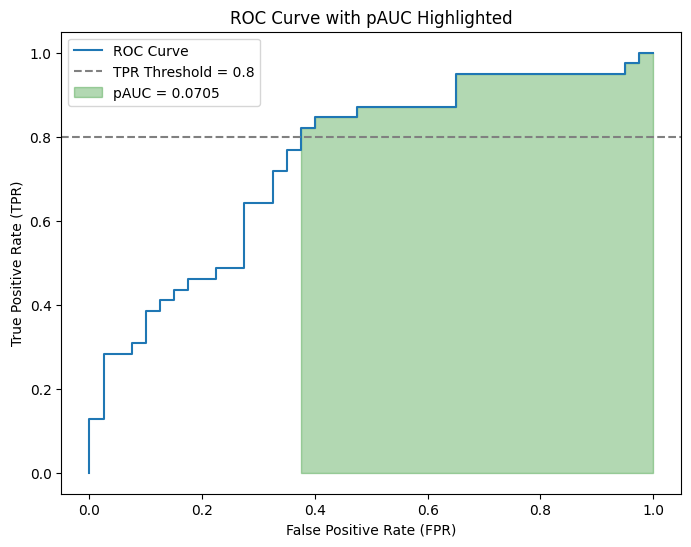

ROC Curve plot saved to saved_models\roc_curve_with_pauc.png


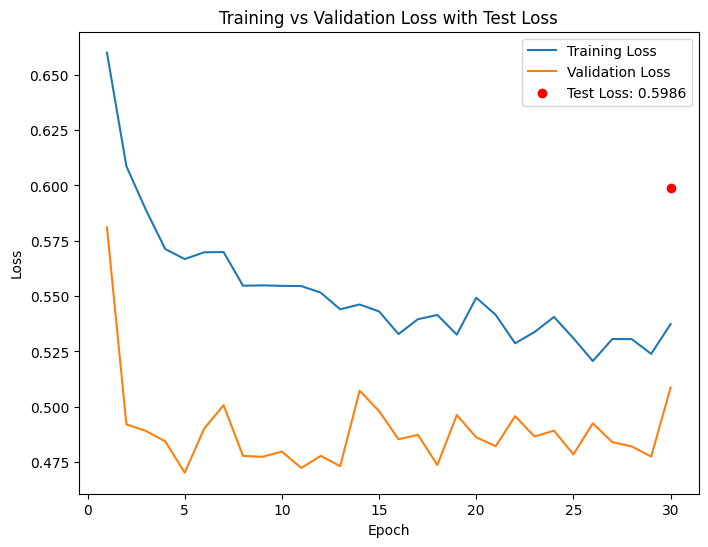

Loss plot saved to saved_models\training_vs_validation_loss.png


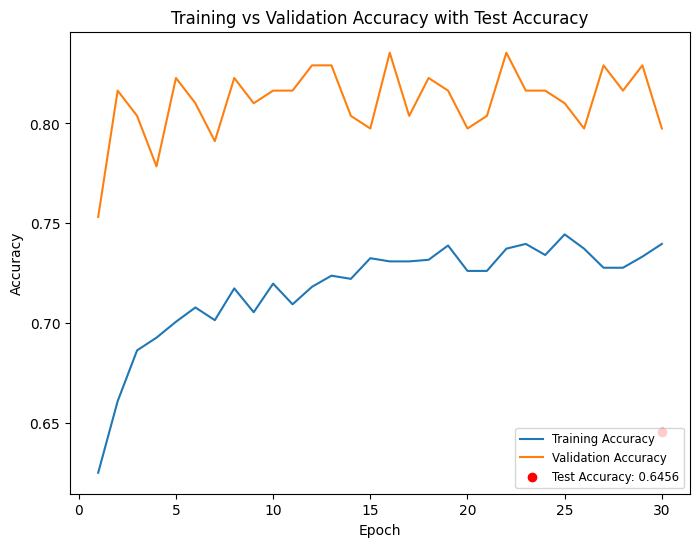

Accuracy plot saved to saved_models\training_vs_validation_accuracy.png


In [ ]:

fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.axhline(y=0.8, color='gray', linestyle='--', label="TPR Threshold = 0.8")
plt.fill_between(fpr, tpr, where=(tpr >= 0.8), color='green', alpha=0.3, label=f"pAUC = {pAUC:.4f}")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve with pAUC Highlighted')
plt.legend()
roc_plot_path = os.path.join(saved_models_dir, "roc_curve_with_pauc.png")
plt.savefig(roc_plot_path)
plt.show()
print(f"ROC Curve plot saved to {roc_plot_path}")


plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.scatter(len(train_losses), avg_test_loss, label=f'Test Loss: {avg_test_loss:.4f}', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss with Test Loss')
plt.legend()
loss_plot_path = os.path.join(saved_models_dir, "training_vs_validation_loss.png")
plt.savefig(loss_plot_path)
plt.show()
print(f"Loss plot saved to {loss_plot_path}")


plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.scatter(len(train_accuracies), test_accuracy, label=f'Test Accuracy: {test_accuracy:.4f}', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy with Test Accuracy')
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0), fontsize='small')  
accuracy_plot_path = os.path.join(saved_models_dir, "training_vs_validation_accuracy.png")
plt.savefig(accuracy_plot_path)
plt.show()
print(f"Accuracy plot saved to {accuracy_plot_path}")

## Write Params


In [ ]:

params_file_path = os.path.join(saved_models_dir, "model_params.txt")
with open(params_file_path, "w") as f:
    f.write("Model Architecture:\n")
    f.write(str(model) + "\n\n")  

    f.write("Hyperparameters:\n")
    f.write(f"Batch Size: {batch_size}\n")
    f.write(f"Learning Rate: {learning_rate}\n")
    f.write(f"Number of Epochs: {num_epochs}\n")
    f.write(f"Number of Classes: {num_classes}\n")
    f.write(f"Dropout Rate: {dropout_rate}\n")
    f.write(f"Optimizer: Adam\n")
    f.write(f"Loss Function: CrossEntropyLoss\n")
print(f"Model parameters and architecture saved to {params_file_path}")


Model parameters and architecture saved to saved_models\model_params.txt
